# TensorFlow

Predict power_W with a Deep Neural Network (DNN) by using TensorFlow and Keras.

-------

## Environment Set-Up

### Load relevant Python Packages

In [1]:
# Importing the most important modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time
from matplotlib import pyplot
import matplotlib.dates as mdates

# For Data Mining
import os, glob
from pandas import read_csv

# Importing metrics to evaluate the implemented models
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow as tf 

### Setup for TensorBoard

We will use the TensorBoard to visualize some results. You can find more information and the board itself at the end of this notebook, but we will define the path were the information should be stored directly here at the beginning. 

In [2]:
# With this command you can clear any logs from previous runs
# If you want to compare different runs you can skip this cell 
!rm -rf my_logs/

In [3]:
# Define path for new directory 
root_logdir = os.path.join(os.curdir, "my_logs")

In [4]:
# Define function for creating a new folder for each run
def get_run_logdir():
    run_id = time.strftime('run_%d_%m_%Y-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

In [5]:
run_logdir = get_run_logdir()

In [6]:
# Create function for using callbacks; "name" should be the name of the model you use
def get_callbacks(name):
    return tf.keras.callbacks.TensorBoard(run_logdir+name, histogram_freq=1)

### Data Import

In [7]:
#data has been saved using a .pkl file 
path = './data/df_model.pkl'
df_model = pd.read_pickle(path)
df_model.head(2)

,dist_km,elv_m,elapsed_time,moving_time,start_time,speed_km/h,pace_min/km,pace_min/100m,power_W,cad,...,dayofyear,hour,minute,second,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,90.80,797.0,12497,12014,51327,27.2,132.3,13.23,186.0,77.0,...,87,14,15,27,0,0,1,0,0,0
1,95.54,769.0,18614,16282,45154,21.1,170.4,17.04,94.0,76.0,...,86,12,32,34,0,1,0,0,0,0


### Setting Up Training & Test Dataframes

The dataframe is split into a training set (80%) and a test set (20%).

In [8]:
# define features and target
X = df_model.drop('power_W', axis=1)
y = df_model.power_W

In [9]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=105)

In [10]:
# Convert to np array
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [11]:
X_train.shape

(88309, 38)

In [12]:
y_train.shape

(88309,)

## Multiple Regression Model with scikit-learn

Before we start using TensorFlow and Keras, let's train a simple `LinearRegression` model from sklearn for comparison. 

In [13]:
# Scaling the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Initalizing and training the model 
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [15]:
# Making predictions 
y_pred = lin_reg.predict(X_test_scaled)

In [16]:
# Calculate r^2
r2 = r2_score(y_test, y_pred, multioutput='uniform_average')

# Return evaluation
print('Mean of power_W:\n', round(df_model['power_W'].mean()))
print('Mean Absolute Error:\n', round(metrics.mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error:\n', round(metrics.mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error:\n', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('R^2:\n', round(r2,ndigits=2))

Mean of power_W:
 163
Mean Absolute Error:
 14
Mean Squared Error:
 582
Root Mean Squared Error:
 24
R^2:
 0.72


In [17]:
# Evaluting model
mae =  mean_absolute_error(y_test, y_pred).round(2)
mse = mean_squared_error(y_test, y_pred).round(2)

print('MAE:', mae)
print('MSE', mse)

MAE: 14.33
MSE 582.17


The result get stored in a dictionary in order to compare the results of different models in the end.

In [18]:
test_results = {}
test_results['sklearn_model'] =  [mae, mse]

### Normalization

In the table of statistics (in [CyPer_EDA](CyPer_EDA.ipynb)) it's easy to see how different the ranges of each feature are.
It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into the model.

The first step is to create the layer:

In [19]:
# Creat normalization layer
normalizer = preprocessing.Normalization()

In [20]:
# Then `.adapt()` it to the data:
normalizer.adapt(np.array(X_train))

This calculates the mean and variance, and stores them in the layer. 
When the layer is called it returns the input data, with each feature independently normalized.

## DNN Regression by using TensorFlow/Keras

This section implements a multiple-input DNN model. The model include five "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

The models contain seven layers:

    1. The normalization layer.
    2. Five hidden, nonlinear, Dense layers using the relu nonlinearity.
    3. A linear single-output layer.
Both will use the same training procedure so we'll include the compile method in the newly defined build_and_compile_model function below.

In [21]:
# Define dictionary to store results
training_history = {}

# Define number of epochs and learning rate decay
N_TRAIN = len(X_train)
EPOCHS = 1000
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.01,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)


# Define optimizer used for modelling
optimizer = tf.keras.optimizers.Adamax(learning_rate=lr_schedule, name='Adamax')

In [22]:
# Function for model_a architecture 
def model_b(norm):
    model_b = tf.keras.Sequential([
      norm,
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', input_dim = 38),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dense(1,kernel_initializer = 'uniform')
    ])

    model_b.compile(optimizer=optimizer,
                  loss='mae',
                  metrics=['mse'])
    return model_b

In [23]:
model_b = model_b(normalizer)

In [24]:
model_b.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 38)                77        
_________________________________________________________________
dense (Dense)                (None, 512)               19968     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               2

In [25]:
%%time
training_history['model_b'] = model_b.fit(X_train,
                     y_train,
                     validation_split=0.2,
                     verbose=0,
                     steps_per_epoch=len(X_train)//BATCH_SIZE,
                     epochs=EPOCHS,
                     callbacks=get_callbacks('model_b'))

CPU times: user 5h 10min 53s, sys: 41min 58s, total: 5h 52min 51s
Wall time: 1h 5min 12s


In [26]:
#Evaluate the model_a on test set using .evaluate
loss, mse = model_b.evaluate(X_test, y_test, verbose=2)
print(f'Model MSE: {mse}')
print('--------'*5)

# Predict values for test set
y_pred = model_b.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))

690/690 - 1s - loss: 0.7356 - mse: 44.6581
Model MSE: 44.65814971923828
----------------------------------------
MSE: 44.65815346643869


### Make Predictions for power_W

Finally, predict have a look at the errors made by the model when making predictions on the test set:

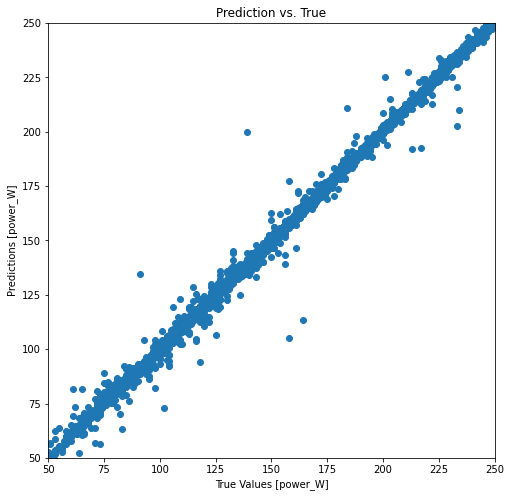

In [62]:
y_pred = model_b.predict(X_test).flatten()


plt.figure(figsize=(8,8))
plt.title("Prediction vs. True")
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [power_W]')
plt.ylabel('Predictions [power_W]')
lims = [50, 250]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

### Error distribution

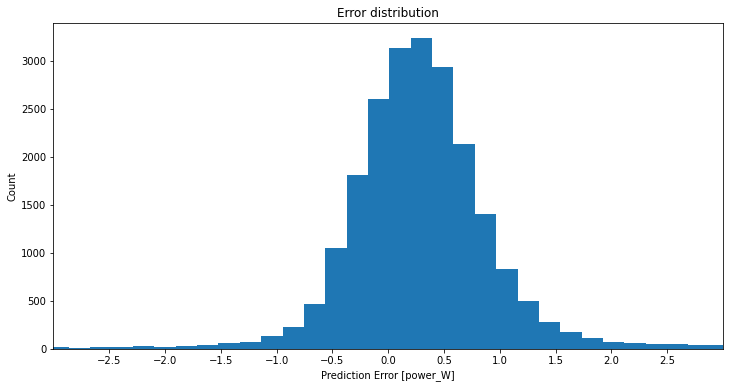

In [63]:
plt.figure(figsize=(12,6))
error = y_pred - y_test
plt.hist(error, bins=5000)
plt.title("Error distribution")
plt.xlabel('Prediction Error [power_W]')
lims = [-3, 3]
plt.xlim(lims)
plt.xticks([-2.5, -2,-1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5])
_ = plt.ylabel('Count')

In [29]:
model_b.save('model_b')

print('This cell was last run on: ')
print(datetime.now())

INFO:tensorflow:Assets written to: model_b/assets


---

## TensorBoard

In machine learning, to improve something you often need to be able to measure it. TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.

In [30]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [31]:
%tensorboard --logdir=./my_logs